In [1]:
%pylab notebook

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from copy import deepcopy
import secrets
import os

import primo.models
import primo.datasets
import primo.tools.sequences as seqtools
from primo.models.cas9_keras import log_multisite_predictor

# Enable memory growth so that we only use as much GPU memory as needed.
# By default, tensorflow will reserve nearly all of the GPU memory.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-t3s2swig because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Populating the interactive namespace from numpy and matplotlib
1 Physical GPUs, 1 Logical GPUs


In [2]:
train_dataset = primo.datasets.OpenImagesTrain(
    '/tf/open_images/train/', switch_every=5*10**4
)
validation_dataset = primo.datasets.OpenImagesVal('/tf/open_images/validation/')

# To see how this value was derived, please consult the Materials and Methods subsection under 
# Feature Extraction section in Bee et. al. 2021. 
similarity_threshold = 75
# Intuitively determined:
batch_size = 20
val_batch_size = 150

def keras_batch_generator(dataset_batch_generator):
    # Yield datasets
    # Each sample is a triplet with known similar and dissimilar images, so the y_true
    # value is unused in the loss function.
    while True:
        # This tuple contains:
        # indices: a positive integer uniquely identifying an image. This index is obtained by
        #   enumerating all the images in the dataset (before splitting them into 
        #   test/train/validate datasets)
        # triplets: A set of three image feature vectos containing anchor, positive (similar) 
        #   image, and negative (dissimilar) image
        indices, triplets = next(dataset_batch_generator)
        yield triplets, np.zeros(len(triplets))

train_batch_generator = keras_batch_generator(
    primo.datasets.dataset.triplet_batch_generator(
        train_dataset.random_features(batch_size),
        similarity_threshold
    )
)

val_batch_generator = keras_batch_generator(
    primo.datasets.dataset.triplet_batch_generator(
        validation_dataset.random_features(val_batch_size),
        similarity_threshold
    )
)

train_inputs, train_targets = next(train_batch_generator)

switching to train_6.h5 and train_2.h5


In [3]:
# The reason the default encoder input is a 4096-dimensional vector is
# because we're representing our images through an embedding that was learned
# by a computer vision model known as VGG [1]. We're borrowing the output of the
# 2nd fully-connected layer (i.e. the FC2), which spits out a 4096-by-1 vector.
#
# If you're very curious about VGG's innerworkings, you can see an example tensorflow
# implementation here [2, 3].
#
# Note for future users: If you ever decide to use a different model VGG16,
# you'd probably want to change the input dimension here.
#
# [1] - https://neurohive.io/en/popular-networks/vgg16/
# [2] - https://www.cs.toronto.edu/~frossard/post/vgg16/
# [3] - https://github.com/kentsommer/VGG16-Image-Retrieval/blob/master/vgg16_example.py#L237
INPUT_FEATURE_SIZE = 4096 

# Each CAS site is 20nt, so the output length should be 20nt for single
# site, and a multiple of 20nt for multiple sites.
OUTPUT_LEN = 20

# Temperature used for softmax calculation
SOFTMAX_TEMP = 1.0

# Optionally, load a previously saved model to continue training
MODEL_FILE=None

def hardmax(temperature):
    def hardmax_f(x):
        y = tf.nn.softmax(x / temperature)
        y_hard = tf.one_hot(tf.argmax(y, -1), 4)
        y = tf.stop_gradient(y_hard - y) + y
        return y
    return hardmax_f

# Create the keras model for a single encoder. This is instantiated three times in the
# model, but trained together -- they will all share a set of weights.
encoder = tf.keras.Sequential([
    layers.Dense(4096, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0000)),
    layers.Dropout(0.2),
    layers.Dense(4096, activation = 'relu', activity_regularizer=tf.keras.regularizers.l2(0.0000)),
    layers.Dropout(0.2),
    layers.Dense(OUTPUT_LEN * 4, activation='relu'),
    layers.Reshape([OUTPUT_LEN, 4]),
    layers.Lambda(hardmax(SOFTMAX_TEMP)),
], name='encoder')

# Start with previously trained model if a filename is provided
if MODEL_FILE is not None:
    encoder = tf.keras.models.load_model(MODEL_FILE)

# First input is anchor, second is a positive sample, third is a negative sample
X_triplets = layers.Input([3, INPUT_FEATURE_SIZE])

# Essentially, we started with a batch of feature-vector triplets...
# ...And turned them into a triplet of feature-vector batches.
X1, X2, X3 = layers.Lambda(lambda X: (X[:,0,:], X[:,1,:], X[:,2,:]))(X_triplets)

# Layer to compute euclidean distances between the triplet pairs for convenience
distances = layers.Lambda(lambda Xs:
                          (
                              tf.sqrt(tf.reduce_sum(tf.square(Xs[0]-Xs[1]), axis=1)),
                              tf.sqrt(tf.reduce_sum(tf.square(Xs[0]-Xs[2]), axis=1))
                          ))([X1,X2,X3])

# Independently transforms the batches of feature vectors into one-hot encoded DNA sequences.
S1 = encoder(X1)
S2 = encoder(X2)
S3 = encoder(X3)

# Glue them back together! Back into a batch of feature vector triplets.
S_triplets = layers.Lambda(
    lambda Ss: tf.stack(Ss, axis=-1)
)([S1,S2,S3])

# Dimensions: (batch_size x 80 x 4 x 3 ) (i.e. batch size x DNA length x # of nucleotides x 3)
# Swaps dimensions for the loss function, which wants (batch-size x 3 x DNA length x 4)
S_triplets_T = layers.Lambda(lambda S: tf.transpose(S, [0, 3, 1, 2]))(S_triplets)

encoder_trainer = tf.keras.Model(inputs=X_triplets, outputs=S_triplets_T)

In [4]:
# Defined the loss function, and metrics used for training

def UniquenessMetric(y_true, y_pred):
    seqs = encoder_trainer(train_inputs)
    # Reduce seqs to a single base (e.g. [0.3, 0.1, 0.5, 0.1] -> [2])
    rounded_seqs = K.argmax(seqs[:, 0, :, :], axis=-1)
    unique_seqs = np.unique(K.get_value(rounded_seqs), axis=0)
    # Return ratio of unique to input
    return float(len(unique_seqs)) / len(train_inputs)

def RecallMetric(y_true, y_pred):
    Yp = log_multisite_predictor(tf.gather(y_pred, [0, 1], axis=1))
    return tf.reduce_mean(tf.cast(Yp > -2.0, tf.float32))

def NegRecallMetric(y_true, y_pred):
    Yn = log_multisite_predictor(tf.gather(y_pred, [0, 2], axis=1))
    return tf.reduce_mean(tf.cast(Yn > -2.0, tf.float32))

class EarlyStopCallback(keras.callbacks.Callback):
    def __init__(self, **kwargs):
        uid = secrets.token_hex(2)
        self.__file = f'/tf/primo/signals/{uid}'
        print(f"Touch {self.__file} to terminate training early")
        super().__init__(**kwargs)


    def on_epoch_end(self, epoch, logs={}):
        if os.path.exists(self.__file):
          print (f"\nStopping after Epoch {epoch}")
          self.model.stop_training = True

class TripletLoss(object):

    def __call__(self, y_true, y_pred):
        """
        y_pred is triplets of (anchor, positive, negative), with dimensions
        batch_size x 3 x 20 x 4
        """
        pos_distance = -log_multisite_predictor(tf.gather(y_pred, [0,1], axis=1))
        neg_distance = log_multisite_predictor(tf.gather(y_pred, [0,2], axis=1))

        # Compute loss function which penalizes low activation rate for positive 
        # pairs, and high activation rate for negative pairs, ignoring samples which
        # are above (positive) or below (negative) thresholds -- i.e. samples which 
        # are already well trained are ignored.
        return tf.maximum(pos_distance, 0.5) + tf.maximum(neg_distance, -3.0)


In [5]:
### 
# Train with full dataset
####
encoder_trainer.compile(
    tf.keras.optimizers.Adagrad(1e-4),
    TripletLoss(),
    run_eagerly=True,
    metrics=[UniquenessMetric, RecallMetric, NegRecallMetric,])
history = encoder_trainer.fit(
    train_batch_generator,
    validation_data=val_batch_generator,
    validation_steps=5,
    steps_per_epoch=100,
    epochs=800,
    callbacks=[EarlyStopCallback()],
)

Touch /tf/primo/signals/9a9b to terminate training early
Epoch 1/800
100/100 [==============================] - 65s 642ms/step - loss: 3.8311 - UniquenessMetric: 0.9705 - RecallMetric: 0.0895 - NegRecallMetric: 0.0665 - val_loss: -0.2680 - val_UniquenessMetric: 0.9000 - val_RecallMetric: 0.8107 - val_NegRecallMetric: 0.6693
Epoch 2/800
100/100 [==============================] - 65s 647ms/step - loss: 0.2455 - UniquenessMetric: 0.7555 - RecallMetric: 0.5060 - NegRecallMetric: 0.4490 - val_loss: 0.0365 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9453 - val_NegRecallMetric: 0.9120
Epoch 3/800
100/100 [==============================] - 64s 641ms/step - loss: 0.0143 - UniquenessMetric: 0.7165 - RecallMetric: 0.6770 - NegRecallMetric: 0.5950 - val_loss: -0.0357 - val_UniquenessMetric: 0.7500 - val_RecallMetric: 0.9440 - val_NegRecallMetric: 0.8960
Epoch 4/800
100/100 [==============================] - 64s 643ms/step - loss: 0.0383 - UniquenessMetric: 0.7565 - RecallMetric: 0.6740 - 

Epoch 23/800
100/100 [==============================] - 65s 648ms/step - loss: -0.6623 - UniquenessMetric: 0.5035 - RecallMetric: 0.8480 - NegRecallMetric: 0.5335 - val_loss: -0.7683 - val_UniquenessMetric: 0.5500 - val_RecallMetric: 0.9093 - val_NegRecallMetric: 0.5760
Epoch 24/800
100/100 [==============================] - 65s 647ms/step - loss: -0.7350 - UniquenessMetric: 0.4855 - RecallMetric: 0.8650 - NegRecallMetric: 0.5270 - val_loss: -0.8607 - val_UniquenessMetric: 0.5000 - val_RecallMetric: 0.9320 - val_NegRecallMetric: 0.5507
Epoch 25/800
100/100 [==============================] - 75s 756ms/step - loss: -0.7436 - UniquenessMetric: 0.5050 - RecallMetric: 0.8660 - NegRecallMetric: 0.5240 - val_loss: -0.8074 - val_UniquenessMetric: 0.5000 - val_RecallMetric: 0.9307 - val_NegRecallMetric: 0.5720
Epoch 26/800
100/100 [==============================] - 65s 646ms/step - loss: -0.7360 - UniquenessMetric: 0.5535 - RecallMetric: 0.8580 - NegRecallMetric: 0.5195 - val_loss: -0.8957 - va

Epoch 50/800
100/100 [==============================] - 75s 753ms/step - loss: -0.7922 - UniquenessMetric: 0.7640 - RecallMetric: 0.8625 - NegRecallMetric: 0.5220 - val_loss: -0.8377 - val_UniquenessMetric: 0.8000 - val_RecallMetric: 0.9267 - val_NegRecallMetric: 0.5880
Epoch 51/800
100/100 [==============================] - 65s 652ms/step - loss: -0.8817 - UniquenessMetric: 0.7780 - RecallMetric: 0.8725 - NegRecallMetric: 0.4895 - val_loss: -0.8878 - val_UniquenessMetric: 0.7500 - val_RecallMetric: 0.9187 - val_NegRecallMetric: 0.5587
Epoch 52/800
100/100 [==============================] - 65s 652ms/step - loss: -0.7980 - UniquenessMetric: 0.7750 - RecallMetric: 0.8565 - NegRecallMetric: 0.5295 - val_loss: -0.8712 - val_UniquenessMetric: 0.8000 - val_RecallMetric: 0.9400 - val_NegRecallMetric: 0.5867
Epoch 53/800
100/100 [==============================] - 65s 650ms/step - loss: -0.8837 - UniquenessMetric: 0.8000 - RecallMetric: 0.8785 - NegRecallMetric: 0.4870 - val_loss: -0.8587 - va

100/100 [==============================] - 65s 650ms/step - loss: -0.9256 - UniquenessMetric: 0.7105 - RecallMetric: 0.8880 - NegRecallMetric: 0.5150 - val_loss: -0.9664 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9493 - val_NegRecallMetric: 0.5747
Epoch 77/800
100/100 [==============================] - 65s 648ms/step - loss: -0.8842 - UniquenessMetric: 0.6920 - RecallMetric: 0.8755 - NegRecallMetric: 0.5185 - val_loss: -0.9146 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9253 - val_NegRecallMetric: 0.5987
Epoch 78/800
100/100 [==============================] - 65s 649ms/step - loss: -0.8817 - UniquenessMetric: 0.7000 - RecallMetric: 0.8795 - NegRecallMetric: 0.5250 - val_loss: -0.9358 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9373 - val_NegRecallMetric: 0.5787
Epoch 79/800
100/100 [==============================] - 64s 644ms/step - loss: -0.8849 - UniquenessMetric: 0.7000 - RecallMetric: 0.8915 - NegRecallMetric: 0.5165 - val_loss: -0.9508 - val_UniquenessM

Epoch 103/800
100/100 [==============================] - 64s 643ms/step - loss: -0.9144 - UniquenessMetric: 0.7000 - RecallMetric: 0.8930 - NegRecallMetric: 0.5110 - val_loss: -0.8829 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9440 - val_NegRecallMetric: 0.5947
Epoch 104/800
100/100 [==============================] - 65s 648ms/step - loss: -0.9042 - UniquenessMetric: 0.7000 - RecallMetric: 0.8925 - NegRecallMetric: 0.5195 - val_loss: -0.9313 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9320 - val_NegRecallMetric: 0.5560
Epoch 105/800
100/100 [==============================] - 75s 753ms/step - loss: -0.9103 - UniquenessMetric: 0.7000 - RecallMetric: 0.8790 - NegRecallMetric: 0.5215 - val_loss: -0.9089 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9493 - val_NegRecallMetric: 0.5787
Epoch 106/800
100/100 [==============================] - 65s 647ms/step - loss: -0.9112 - UniquenessMetric: 0.7000 - RecallMetric: 0.8960 - NegRecallMetric: 0.5365 - val_loss: -0.9436 

Epoch 130/800
switching to train_a.h5 and train_1.h5
100/100 [==============================] - 75s 752ms/step - loss: -0.9804 - UniquenessMetric: 0.6350 - RecallMetric: 0.8930 - NegRecallMetric: 0.5105 - val_loss: -0.9174 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9253 - val_NegRecallMetric: 0.5720
Epoch 131/800
100/100 [==============================] - 64s 643ms/step - loss: -0.9459 - UniquenessMetric: 0.6790 - RecallMetric: 0.8890 - NegRecallMetric: 0.5140 - val_loss: -0.9107 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9360 - val_NegRecallMetric: 0.5853
Epoch 132/800
100/100 [==============================] - 64s 644ms/step - loss: -0.9173 - UniquenessMetric: 0.6580 - RecallMetric: 0.8955 - NegRecallMetric: 0.5310 - val_loss: -0.9323 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9427 - val_NegRecallMetric: 0.5827
Epoch 133/800
100/100 [==============================] - 64s 639ms/step - loss: -0.9044 - UniquenessMetric: 0.6770 - RecallMetric: 0.8850 - NegRe

Epoch 157/800
100/100 [==============================] - 65s 650ms/step - loss: -0.9536 - UniquenessMetric: 0.5500 - RecallMetric: 0.8965 - NegRecallMetric: 0.5370 - val_loss: -0.8724 - val_UniquenessMetric: 0.5500 - val_RecallMetric: 0.9360 - val_NegRecallMetric: 0.5973
Epoch 158/800
100/100 [==============================] - 64s 645ms/step - loss: -0.9367 - UniquenessMetric: 0.5500 - RecallMetric: 0.8925 - NegRecallMetric: 0.5140 - val_loss: -0.8933 - val_UniquenessMetric: 0.5500 - val_RecallMetric: 0.9387 - val_NegRecallMetric: 0.6000
Epoch 159/800
100/100 [==============================] - 75s 753ms/step - loss: -0.9759 - UniquenessMetric: 0.5500 - RecallMetric: 0.8895 - NegRecallMetric: 0.4980 - val_loss: -0.9968 - val_UniquenessMetric: 0.5500 - val_RecallMetric: 0.9373 - val_NegRecallMetric: 0.5307
Epoch 160/800
100/100 [==============================] - 65s 649ms/step - loss: -0.9310 - UniquenessMetric: 0.5505 - RecallMetric: 0.8855 - NegRecallMetric: 0.5205 - val_loss: -0.9224 

Epoch 184/800
100/100 [==============================] - 75s 749ms/step - loss: -0.9125 - UniquenessMetric: 0.5500 - RecallMetric: 0.8870 - NegRecallMetric: 0.5315 - val_loss: -0.9865 - val_UniquenessMetric: 0.5500 - val_RecallMetric: 0.9507 - val_NegRecallMetric: 0.5440
Epoch 185/800
100/100 [==============================] - 65s 647ms/step - loss: -0.9391 - UniquenessMetric: 0.5500 - RecallMetric: 0.8985 - NegRecallMetric: 0.5325 - val_loss: -0.9463 - val_UniquenessMetric: 0.5500 - val_RecallMetric: 0.9333 - val_NegRecallMetric: 0.5827
Epoch 186/800
100/100 [==============================] - 64s 643ms/step - loss: -0.9773 - UniquenessMetric: 0.5500 - RecallMetric: 0.8945 - NegRecallMetric: 0.5045 - val_loss: -0.9212 - val_UniquenessMetric: 0.5500 - val_RecallMetric: 0.9307 - val_NegRecallMetric: 0.5720
Epoch 187/800
100/100 [==============================] - 64s 644ms/step - loss: -0.9573 - UniquenessMetric: 0.5500 - RecallMetric: 0.8835 - NegRecallMetric: 0.5150 - val_loss: -0.9825 

100/100 [==============================] - 63s 634ms/step - loss: -0.9509 - UniquenessMetric: 0.5500 - RecallMetric: 0.8965 - NegRecallMetric: 0.5160 - val_loss: -1.0182 - val_UniquenessMetric: 0.5500 - val_RecallMetric: 0.9480 - val_NegRecallMetric: 0.5480
Epoch 211/800
100/100 [==============================] - 63s 632ms/step - loss: -0.9036 - UniquenessMetric: 0.5500 - RecallMetric: 0.8920 - NegRecallMetric: 0.5320 - val_loss: -0.8869 - val_UniquenessMetric: 0.5500 - val_RecallMetric: 0.9333 - val_NegRecallMetric: 0.5787
Epoch 212/800
100/100 [==============================] - 63s 633ms/step - loss: -0.9341 - UniquenessMetric: 0.5500 - RecallMetric: 0.8865 - NegRecallMetric: 0.5055 - val_loss: -0.9654 - val_UniquenessMetric: 0.5500 - val_RecallMetric: 0.9587 - val_NegRecallMetric: 0.5813
Epoch 213/800
100/100 [==============================] - 64s 635ms/step - loss: -0.9368 - UniquenessMetric: 0.5500 - RecallMetric: 0.8880 - NegRecallMetric: 0.5150 - val_loss: -0.9090 - val_Uniquene

Epoch 237/800
100/100 [==============================] - 64s 637ms/step - loss: -0.9019 - UniquenessMetric: 0.5880 - RecallMetric: 0.8850 - NegRecallMetric: 0.5250 - val_loss: -0.9091 - val_UniquenessMetric: 0.6000 - val_RecallMetric: 0.9427 - val_NegRecallMetric: 0.5987
Epoch 238/800
100/100 [==============================] - 64s 637ms/step - loss: -0.9318 - UniquenessMetric: 0.6000 - RecallMetric: 0.8880 - NegRecallMetric: 0.5275 - val_loss: -0.9163 - val_UniquenessMetric: 0.6000 - val_RecallMetric: 0.9227 - val_NegRecallMetric: 0.5680
Epoch 239/800
100/100 [==============================] - 74s 744ms/step - loss: -0.9538 - UniquenessMetric: 0.5850 - RecallMetric: 0.8945 - NegRecallMetric: 0.5175 - val_loss: -0.9917 - val_UniquenessMetric: 0.6000 - val_RecallMetric: 0.9413 - val_NegRecallMetric: 0.5613
Epoch 240/800
100/100 [==============================] - 64s 642ms/step - loss: -0.9178 - UniquenessMetric: 0.5770 - RecallMetric: 0.8895 - NegRecallMetric: 0.5190 - val_loss: -1.0208 

Epoch 264/800
100/100 [==============================] - 75s 749ms/step - loss: -0.9724 - UniquenessMetric: 0.5750 - RecallMetric: 0.8960 - NegRecallMetric: 0.5060 - val_loss: -0.9821 - val_UniquenessMetric: 0.6000 - val_RecallMetric: 0.9440 - val_NegRecallMetric: 0.5653
Epoch 265/800
100/100 [==============================] - 65s 645ms/step - loss: -0.9174 - UniquenessMetric: 0.5840 - RecallMetric: 0.9020 - NegRecallMetric: 0.5375 - val_loss: -0.9527 - val_UniquenessMetric: 0.6000 - val_RecallMetric: 0.9333 - val_NegRecallMetric: 0.5547
Epoch 266/800
100/100 [==============================] - 64s 645ms/step - loss: -0.9731 - UniquenessMetric: 0.5920 - RecallMetric: 0.8925 - NegRecallMetric: 0.5120 - val_loss: -0.9745 - val_UniquenessMetric: 0.6000 - val_RecallMetric: 0.9347 - val_NegRecallMetric: 0.5333
Epoch 267/800
100/100 [==============================] - 64s 644ms/step - loss: -0.9105 - UniquenessMetric: 0.6000 - RecallMetric: 0.8890 - NegRecallMetric: 0.5405 - val_loss: -0.9135 

Epoch 291/800
100/100 [==============================] - 65s 646ms/step - loss: -1.0047 - UniquenessMetric: 0.5500 - RecallMetric: 0.9010 - NegRecallMetric: 0.5035 - val_loss: -0.9719 - val_UniquenessMetric: 0.5500 - val_RecallMetric: 0.9493 - val_NegRecallMetric: 0.5840
Epoch 292/800
100/100 [==============================] - 65s 649ms/step - loss: -0.9615 - UniquenessMetric: 0.5500 - RecallMetric: 0.8980 - NegRecallMetric: 0.5135 - val_loss: -0.9972 - val_UniquenessMetric: 0.5500 - val_RecallMetric: 0.9533 - val_NegRecallMetric: 0.5387
Epoch 293/800
100/100 [==============================] - 75s 754ms/step - loss: -0.9550 - UniquenessMetric: 0.5500 - RecallMetric: 0.9010 - NegRecallMetric: 0.5240 - val_loss: -0.9758 - val_UniquenessMetric: 0.5500 - val_RecallMetric: 0.9533 - val_NegRecallMetric: 0.5520
Epoch 294/800
100/100 [==============================] - 65s 650ms/step - loss: -0.9026 - UniquenessMetric: 0.5500 - RecallMetric: 0.8860 - NegRecallMetric: 0.5320 - val_loss: -0.9152 

Epoch 318/800
100/100 [==============================] - 76s 757ms/step - loss: -1.0048 - UniquenessMetric: 0.6000 - RecallMetric: 0.8925 - NegRecallMetric: 0.4845 - val_loss: -0.9777 - val_UniquenessMetric: 0.6000 - val_RecallMetric: 0.9587 - val_NegRecallMetric: 0.5813
Epoch 319/800
100/100 [==============================] - 65s 648ms/step - loss: -0.9476 - UniquenessMetric: 0.6000 - RecallMetric: 0.8930 - NegRecallMetric: 0.5300 - val_loss: -0.9549 - val_UniquenessMetric: 0.6000 - val_RecallMetric: 0.9413 - val_NegRecallMetric: 0.5693
Epoch 320/800
100/100 [==============================] - 65s 650ms/step - loss: -1.0141 - UniquenessMetric: 0.6000 - RecallMetric: 0.9095 - NegRecallMetric: 0.4900 - val_loss: -0.8733 - val_UniquenessMetric: 0.6000 - val_RecallMetric: 0.9413 - val_NegRecallMetric: 0.5933
Epoch 321/800
100/100 [==============================] - 65s 650ms/step - loss: -0.9315 - UniquenessMetric: 0.6000 - RecallMetric: 0.8960 - NegRecallMetric: 0.5260 - val_loss: -0.9338 

100/100 [==============================] - 65s 648ms/step - loss: -0.9835 - UniquenessMetric: 0.6000 - RecallMetric: 0.9010 - NegRecallMetric: 0.5130 - val_loss: -1.0185 - val_UniquenessMetric: 0.6000 - val_RecallMetric: 0.9613 - val_NegRecallMetric: 0.5480
Epoch 345/800
100/100 [==============================] - 64s 645ms/step - loss: -0.9516 - UniquenessMetric: 0.6000 - RecallMetric: 0.8975 - NegRecallMetric: 0.5340 - val_loss: -0.9353 - val_UniquenessMetric: 0.6000 - val_RecallMetric: 0.9493 - val_NegRecallMetric: 0.5720
Epoch 346/800
100/100 [==============================] - 65s 650ms/step - loss: -0.9357 - UniquenessMetric: 0.6000 - RecallMetric: 0.8960 - NegRecallMetric: 0.5360 - val_loss: -0.9739 - val_UniquenessMetric: 0.6000 - val_RecallMetric: 0.9453 - val_NegRecallMetric: 0.5653
Epoch 347/800
100/100 [==============================] - 65s 648ms/step - loss: -0.9275 - UniquenessMetric: 0.6000 - RecallMetric: 0.8815 - NegRecallMetric: 0.5160 - val_loss: -0.8874 - val_Uniquene

Epoch 371/800
100/100 [==============================] - 65s 647ms/step - loss: -0.9147 - UniquenessMetric: 0.6010 - RecallMetric: 0.8900 - NegRecallMetric: 0.5345 - val_loss: -0.9235 - val_UniquenessMetric: 0.6000 - val_RecallMetric: 0.9520 - val_NegRecallMetric: 0.5613
Epoch 372/800
100/100 [==============================] - 64s 644ms/step - loss: -0.9293 - UniquenessMetric: 0.6430 - RecallMetric: 0.8815 - NegRecallMetric: 0.5185 - val_loss: -1.0362 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9427 - val_NegRecallMetric: 0.5480
Epoch 373/800
100/100 [==============================] - 75s 754ms/step - loss: -0.9057 - UniquenessMetric: 0.6430 - RecallMetric: 0.8945 - NegRecallMetric: 0.5355 - val_loss: -1.0244 - val_UniquenessMetric: 0.6000 - val_RecallMetric: 0.9480 - val_NegRecallMetric: 0.5280
Epoch 374/800
100/100 [==============================] - 65s 651ms/step - loss: -0.9536 - UniquenessMetric: 0.6065 - RecallMetric: 0.8995 - NegRecallMetric: 0.5385 - val_loss: -0.9860 

Epoch 398/800
100/100 [==============================] - 75s 753ms/step - loss: -0.9559 - UniquenessMetric: 0.6500 - RecallMetric: 0.8910 - NegRecallMetric: 0.5175 - val_loss: -0.9480 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9560 - val_NegRecallMetric: 0.5933
Epoch 399/800
100/100 [==============================] - 65s 647ms/step - loss: -0.9523 - UniquenessMetric: 0.6500 - RecallMetric: 0.8930 - NegRecallMetric: 0.5235 - val_loss: -0.9616 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9573 - val_NegRecallMetric: 0.5693
Epoch 400/800
100/100 [==============================] - 65s 648ms/step - loss: -0.9413 - UniquenessMetric: 0.6500 - RecallMetric: 0.8970 - NegRecallMetric: 0.5175 - val_loss: -0.9112 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9280 - val_NegRecallMetric: 0.5800
Epoch 401/800
100/100 [==============================] - 65s 647ms/step - loss: -0.9439 - UniquenessMetric: 0.6500 - RecallMetric: 0.8955 - NegRecallMetric: 0.5200 - val_loss: -0.9784 

100/100 [==============================] - 64s 644ms/step - loss: -0.9570 - UniquenessMetric: 0.7000 - RecallMetric: 0.9025 - NegRecallMetric: 0.5230 - val_loss: -0.9168 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9533 - val_NegRecallMetric: 0.6067
Epoch 425/800
100/100 [==============================] - 65s 645ms/step - loss: -0.9189 - UniquenessMetric: 0.7000 - RecallMetric: 0.8865 - NegRecallMetric: 0.5300 - val_loss: -0.9026 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9400 - val_NegRecallMetric: 0.5907
Epoch 426/800
100/100 [==============================] - 64s 643ms/step - loss: -0.9460 - UniquenessMetric: 0.6615 - RecallMetric: 0.8950 - NegRecallMetric: 0.5295 - val_loss: -0.9735 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9520 - val_NegRecallMetric: 0.5680
Epoch 427/800
100/100 [==============================] - 64s 644ms/step - loss: -0.9322 - UniquenessMetric: 0.6500 - RecallMetric: 0.8865 - NegRecallMetric: 0.5220 - val_loss: -0.9995 - val_Uniquene

Epoch 451/800
100/100 [==============================] - 65s 647ms/step - loss: -0.9734 - UniquenessMetric: 0.6500 - RecallMetric: 0.9025 - NegRecallMetric: 0.5300 - val_loss: -0.9848 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9240 - val_NegRecallMetric: 0.5640
Epoch 452/800
100/100 [==============================] - 75s 751ms/step - loss: -0.9497 - UniquenessMetric: 0.6500 - RecallMetric: 0.8970 - NegRecallMetric: 0.5170 - val_loss: -0.9541 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9373 - val_NegRecallMetric: 0.5587
Epoch 453/800
100/100 [==============================] - 65s 649ms/step - loss: -1.0005 - UniquenessMetric: 0.6500 - RecallMetric: 0.8995 - NegRecallMetric: 0.5035 - val_loss: -0.9709 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9373 - val_NegRecallMetric: 0.5507
Epoch 454/800
100/100 [==============================] - 65s 647ms/step - loss: -0.9932 - UniquenessMetric: 0.6500 - RecallMetric: 0.9090 - NegRecallMetric: 0.5170 - val_loss: -1.0073 

100/100 [==============================] - 75s 752ms/step - loss: -0.9855 - UniquenessMetric: 0.6640 - RecallMetric: 0.8970 - NegRecallMetric: 0.5185 - val_loss: -0.9284 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9320 - val_NegRecallMetric: 0.5667
Epoch 478/800
100/100 [==============================] - 64s 642ms/step - loss: -0.9797 - UniquenessMetric: 0.6500 - RecallMetric: 0.8955 - NegRecallMetric: 0.5110 - val_loss: -0.9788 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9440 - val_NegRecallMetric: 0.5640
Epoch 479/800
100/100 [==============================] - 64s 643ms/step - loss: -0.9864 - UniquenessMetric: 0.6500 - RecallMetric: 0.8960 - NegRecallMetric: 0.5155 - val_loss: -0.9266 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9373 - val_NegRecallMetric: 0.5827
Epoch 480/800
100/100 [==============================] - 64s 644ms/step - loss: -0.9280 - UniquenessMetric: 0.6500 - RecallMetric: 0.8920 - NegRecallMetric: 0.5315 - val_loss: -0.9439 - val_Uniquene

Epoch 504/800
100/100 [==============================] - 65s 649ms/step - loss: -0.9191 - UniquenessMetric: 0.7000 - RecallMetric: 0.8890 - NegRecallMetric: 0.5380 - val_loss: -0.9715 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9493 - val_NegRecallMetric: 0.5640
Epoch 505/800
100/100 [==============================] - 65s 649ms/step - loss: -0.9668 - UniquenessMetric: 0.6740 - RecallMetric: 0.8950 - NegRecallMetric: 0.5210 - val_loss: -1.0803 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9493 - val_NegRecallMetric: 0.5560
Epoch 506/800
100/100 [==============================] - 65s 649ms/step - loss: -0.9857 - UniquenessMetric: 0.6500 - RecallMetric: 0.9075 - NegRecallMetric: 0.5150 - val_loss: -1.0254 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9440 - val_NegRecallMetric: 0.5400
Epoch 507/800
100/100 [==============================] - 75s 755ms/step - loss: -0.9525 - UniquenessMetric: 0.6500 - RecallMetric: 0.9020 - NegRecallMetric: 0.5415 - val_loss: -1.0318 

Epoch 531/800
100/100 [==============================] - 64s 644ms/step - loss: -0.9655 - UniquenessMetric: 0.6755 - RecallMetric: 0.8980 - NegRecallMetric: 0.5200 - val_loss: -0.9324 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9387 - val_NegRecallMetric: 0.5667
Epoch 532/800
100/100 [==============================] - 76s 757ms/step - loss: -0.9220 - UniquenessMetric: 0.6505 - RecallMetric: 0.8915 - NegRecallMetric: 0.5230 - val_loss: -0.9749 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9587 - val_NegRecallMetric: 0.5573
Epoch 533/800
100/100 [==============================] - 65s 648ms/step - loss: -0.9500 - UniquenessMetric: 0.6535 - RecallMetric: 0.9030 - NegRecallMetric: 0.5365 - val_loss: -1.0320 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9520 - val_NegRecallMetric: 0.5400
Epoch 534/800
100/100 [==============================] - 65s 648ms/step - loss: -0.9629 - UniquenessMetric: 0.6685 - RecallMetric: 0.8915 - NegRecallMetric: 0.5315 - val_loss: -0.8822 

100/100 [==============================] - 75s 748ms/step - loss: -0.9348 - UniquenessMetric: 0.6895 - RecallMetric: 0.8940 - NegRecallMetric: 0.5240 - val_loss: -0.9204 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9413 - val_NegRecallMetric: 0.5760
Epoch 558/800
100/100 [==============================] - 65s 645ms/step - loss: -0.9639 - UniquenessMetric: 0.7000 - RecallMetric: 0.9030 - NegRecallMetric: 0.5325 - val_loss: -1.0167 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9533 - val_NegRecallMetric: 0.5373
Epoch 559/800
100/100 [==============================] - 65s 648ms/step - loss: -0.9532 - UniquenessMetric: 0.7000 - RecallMetric: 0.8940 - NegRecallMetric: 0.5290 - val_loss: -0.9292 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9547 - val_NegRecallMetric: 0.5813
Epoch 560/800
100/100 [==============================] - 65s 647ms/step - loss: -1.0060 - UniquenessMetric: 0.7000 - RecallMetric: 0.9005 - NegRecallMetric: 0.5165 - val_loss: -0.9292 - val_Uniquene

Epoch 584/800
100/100 [==============================] - 64s 639ms/step - loss: -0.9398 - UniquenessMetric: 0.7000 - RecallMetric: 0.8955 - NegRecallMetric: 0.5250 - val_loss: -1.0673 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9587 - val_NegRecallMetric: 0.5333
Epoch 585/800
100/100 [==============================] - 64s 637ms/step - loss: -0.9477 - UniquenessMetric: 0.7000 - RecallMetric: 0.8875 - NegRecallMetric: 0.5040 - val_loss: -0.9554 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9520 - val_NegRecallMetric: 0.5907
Epoch 586/800
100/100 [==============================] - 75s 749ms/step - loss: -0.9820 - UniquenessMetric: 0.7000 - RecallMetric: 0.9055 - NegRecallMetric: 0.5190 - val_loss: -0.9779 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9240 - val_NegRecallMetric: 0.5467
Epoch 587/800
100/100 [==============================] - 65s 653ms/step - loss: -1.0080 - UniquenessMetric: 0.7000 - RecallMetric: 0.9075 - NegRecallMetric: 0.5185 - val_loss: -0.9813 

Epoch 611/800
100/100 [==============================] - 75s 751ms/step - loss: -1.0090 - UniquenessMetric: 0.6545 - RecallMetric: 0.9130 - NegRecallMetric: 0.5140 - val_loss: -0.8655 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9360 - val_NegRecallMetric: 0.6053
Epoch 612/800
100/100 [==============================] - 65s 647ms/step - loss: -0.9519 - UniquenessMetric: 0.7000 - RecallMetric: 0.8885 - NegRecallMetric: 0.5105 - val_loss: -1.0545 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9533 - val_NegRecallMetric: 0.5533
Epoch 613/800
100/100 [==============================] - 64s 641ms/step - loss: -0.9983 - UniquenessMetric: 0.7000 - RecallMetric: 0.9050 - NegRecallMetric: 0.5005 - val_loss: -1.0404 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9413 - val_NegRecallMetric: 0.5480
Epoch 614/800
100/100 [==============================] - 65s 648ms/step - loss: -0.9833 - UniquenessMetric: 0.7000 - RecallMetric: 0.9000 - NegRecallMetric: 0.5165 - val_loss: -0.9541 

100/100 [==============================] - 64s 642ms/step - loss: -0.9674 - UniquenessMetric: 0.6500 - RecallMetric: 0.9010 - NegRecallMetric: 0.5100 - val_loss: -1.0369 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9533 - val_NegRecallMetric: 0.5480
Epoch 638/800
100/100 [==============================] - 64s 645ms/step - loss: -0.9307 - UniquenessMetric: 0.6500 - RecallMetric: 0.8900 - NegRecallMetric: 0.5290 - val_loss: -0.9471 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9373 - val_NegRecallMetric: 0.5600
Epoch 639/800
100/100 [==============================] - 65s 646ms/step - loss: -0.9307 - UniquenessMetric: 0.6500 - RecallMetric: 0.8950 - NegRecallMetric: 0.5355 - val_loss: -0.9626 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9387 - val_NegRecallMetric: 0.5640
Epoch 640/800
100/100 [==============================] - 64s 640ms/step - loss: -0.9789 - UniquenessMetric: 0.6500 - RecallMetric: 0.9065 - NegRecallMetric: 0.5215 - val_loss: -0.9175 - val_Uniquene

Epoch 664/800
100/100 [==============================] - 65s 648ms/step - loss: -0.9583 - UniquenessMetric: 0.6500 - RecallMetric: 0.8900 - NegRecallMetric: 0.5150 - val_loss: -0.9648 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9373 - val_NegRecallMetric: 0.5787
Epoch 665/800
100/100 [==============================] - 65s 650ms/step - loss: -0.9803 - UniquenessMetric: 0.6500 - RecallMetric: 0.9000 - NegRecallMetric: 0.5180 - val_loss: -0.9775 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9507 - val_NegRecallMetric: 0.5787
Epoch 666/800
100/100 [==============================] - 76s 758ms/step - loss: -0.9946 - UniquenessMetric: 0.6500 - RecallMetric: 0.9020 - NegRecallMetric: 0.5140 - val_loss: -0.9578 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9413 - val_NegRecallMetric: 0.5827
Epoch 667/800
100/100 [==============================] - 65s 651ms/step - loss: -1.0104 - UniquenessMetric: 0.6500 - RecallMetric: 0.9040 - NegRecallMetric: 0.5115 - val_loss: -1.0179 

Epoch 691/800
100/100 [==============================] - 75s 753ms/step - loss: -1.0185 - UniquenessMetric: 0.6500 - RecallMetric: 0.9115 - NegRecallMetric: 0.5135 - val_loss: -1.0053 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9600 - val_NegRecallMetric: 0.5600
Epoch 692/800
100/100 [==============================] - 65s 646ms/step - loss: -0.9789 - UniquenessMetric: 0.6500 - RecallMetric: 0.8970 - NegRecallMetric: 0.5235 - val_loss: -1.0542 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9600 - val_NegRecallMetric: 0.5520
Epoch 693/800
100/100 [==============================] - 65s 648ms/step - loss: -0.9538 - UniquenessMetric: 0.6500 - RecallMetric: 0.8885 - NegRecallMetric: 0.5160 - val_loss: -0.9644 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9280 - val_NegRecallMetric: 0.5680
Epoch 694/800
100/100 [==============================] - 65s 646ms/step - loss: -0.9343 - UniquenessMetric: 0.6500 - RecallMetric: 0.8945 - NegRecallMetric: 0.5340 - val_loss: -0.9136 

100/100 [==============================] - 65s 647ms/step - loss: -0.9740 - UniquenessMetric: 0.6500 - RecallMetric: 0.8960 - NegRecallMetric: 0.4995 - val_loss: -0.9389 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9387 - val_NegRecallMetric: 0.5467
Epoch 718/800
100/100 [==============================] - 65s 651ms/step - loss: -0.9794 - UniquenessMetric: 0.6500 - RecallMetric: 0.8905 - NegRecallMetric: 0.5165 - val_loss: -0.9748 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9520 - val_NegRecallMetric: 0.5720
Epoch 719/800
100/100 [==============================] - 65s 648ms/step - loss: -1.0079 - UniquenessMetric: 0.6500 - RecallMetric: 0.8940 - NegRecallMetric: 0.5000 - val_loss: -0.9803 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9387 - val_NegRecallMetric: 0.5720
Epoch 720/800
100/100 [==============================] - 64s 645ms/step - loss: -0.9661 - UniquenessMetric: 0.6500 - RecallMetric: 0.8985 - NegRecallMetric: 0.5170 - val_loss: -1.0051 - val_Uniquene

Epoch 744/800
100/100 [==============================] - 64s 644ms/step - loss: -0.9429 - UniquenessMetric: 0.6560 - RecallMetric: 0.8935 - NegRecallMetric: 0.5315 - val_loss: -1.0253 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9400 - val_NegRecallMetric: 0.5320
Epoch 745/800
100/100 [==============================] - 76s 759ms/step - loss: -0.9621 - UniquenessMetric: 0.6500 - RecallMetric: 0.8990 - NegRecallMetric: 0.5140 - val_loss: -0.9764 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9560 - val_NegRecallMetric: 0.5773
Epoch 746/800
100/100 [==============================] - 65s 650ms/step - loss: -0.9645 - UniquenessMetric: 0.6650 - RecallMetric: 0.9015 - NegRecallMetric: 0.5260 - val_loss: -0.9416 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9507 - val_NegRecallMetric: 0.5707
Epoch 747/800
100/100 [==============================] - 65s 649ms/step - loss: -0.9615 - UniquenessMetric: 0.7000 - RecallMetric: 0.8765 - NegRecallMetric: 0.5000 - val_loss: -0.9652 

100/100 [==============================] - 74s 745ms/step - loss: -0.9885 - UniquenessMetric: 0.7110 - RecallMetric: 0.9030 - NegRecallMetric: 0.5170 - val_loss: -0.9531 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9453 - val_NegRecallMetric: 0.5960
Epoch 771/800
100/100 [==============================] - 63s 631ms/step - loss: -1.0022 - UniquenessMetric: 0.7415 - RecallMetric: 0.8915 - NegRecallMetric: 0.4960 - val_loss: -1.0167 - val_UniquenessMetric: 0.7000 - val_RecallMetric: 0.9467 - val_NegRecallMetric: 0.5627
Epoch 772/800
100/100 [==============================] - 63s 633ms/step - loss: -0.9695 - UniquenessMetric: 0.7070 - RecallMetric: 0.8935 - NegRecallMetric: 0.5010 - val_loss: -0.9247 - val_UniquenessMetric: 0.7500 - val_RecallMetric: 0.9387 - val_NegRecallMetric: 0.5920
Epoch 773/800
100/100 [==============================] - 63s 635ms/step - loss: -0.9702 - UniquenessMetric: 0.6900 - RecallMetric: 0.8885 - NegRecallMetric: 0.5190 - val_loss: -1.0044 - val_Uniquene

Epoch 797/800
100/100 [==============================] - 65s 646ms/step - loss: -0.9657 - UniquenessMetric: 0.6500 - RecallMetric: 0.8925 - NegRecallMetric: 0.5180 - val_loss: -1.0026 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9493 - val_NegRecallMetric: 0.5373
Epoch 798/800
100/100 [==============================] - 64s 642ms/step - loss: -1.0226 - UniquenessMetric: 0.6500 - RecallMetric: 0.9005 - NegRecallMetric: 0.5060 - val_loss: -0.8929 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9440 - val_NegRecallMetric: 0.5987
Epoch 799/800
100/100 [==============================] - 64s 644ms/step - loss: -0.9551 - UniquenessMetric: 0.6500 - RecallMetric: 0.8880 - NegRecallMetric: 0.5135 - val_loss: -0.9674 - val_UniquenessMetric: 0.6500 - val_RecallMetric: 0.9493 - val_NegRecallMetric: 0.5520
Epoch 800/800
100/100 [==============================] - 74s 738ms/step - loss: -1.0297 - UniquenessMetric: 0.6500 - RecallMetric: 0.9055 - NegRecallMetric: 0.5095 - val_loss: -0.9510 

In [6]:

encoder.save('/tf/primo/data/models/encoder_1site_model_20220615.h5')

<IPython.core.display.Javascript object>


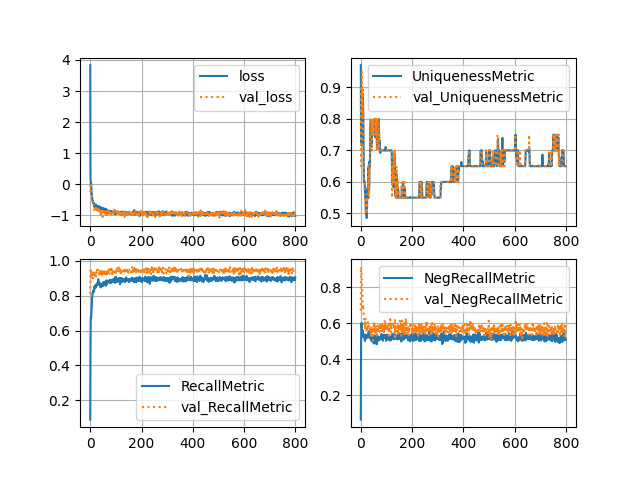

In [8]:
# Plot training history
fig = plt.figure()
lines = [k for k in history.history.keys() if not k.startswith('val_')]
axes = fig.subplots(int(len(lines)/2), 2)
for i in range(len(lines)):
    label = lines[i]
    ax = axes.flatten()[i]
    val_label = 'val_' + label
    ax.plot(history.history[label], label=label)
    if val_label in history.history:
        ax.plot(history.history[val_label], linestyle=':', label=val_label)
        ax.grid()
    ax.legend()